# Grouped By Graph Type CNN Model With Contamination Using Heatmaps - Conati Architecture With 5x5 Kernel

In [10]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Heatmaps" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Heatmaps" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Heatmaps")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Heatmaps/organized_by_graph_type (at project root)
base_dataset_path = os.path.join(project_root, "Heatmaps", "organized_by_graph_type")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [12]:

# Function to create a model (based on the paper's CNN architecture, with original input size)
def create_model():
    model = models.Sequential([
        layers.Input(shape=(288, 512, 3)),  # Color images

        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(6, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB by default)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # # Convert RGB to grayscale
    # def convert_to_grayscale(image, label):
    #     image = tf.image.rgb_to_grayscale(image)
    #     return image, label
    #
    # train_ds = train_ds.map(convert_to_grayscale)
    # val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")



=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.5391 - loss: 616.1342 - val_accuracy: 0.5548 - val_loss: 0.7252
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5824 - loss: 0.6814 - val_accuracy: 0.5677 - val_loss: 0.6782
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.6292 - loss: 0.6475 - val_accuracy: 0.6129 - val_loss: 0.6710
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.7083 - loss: 0.6049 - val_accuracy: 0.6258 - val_loss: 0.6576
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.6975 - loss: 0.5509 - val_accuracy: 0.6129 - val_loss: 0.6740
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.7236 - loss: 0.5434 - val_accuracy: 0.6000 - val_loss: 0.6722
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step 

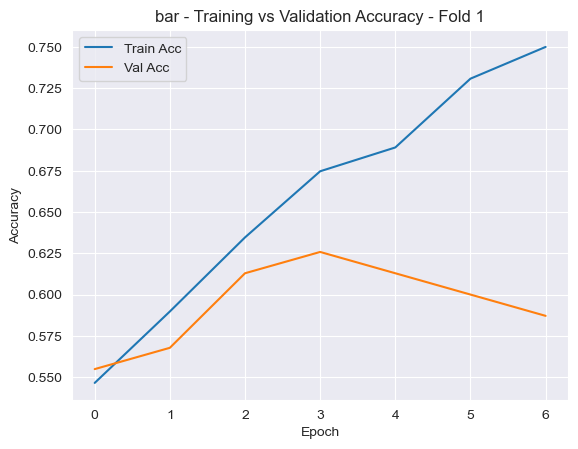

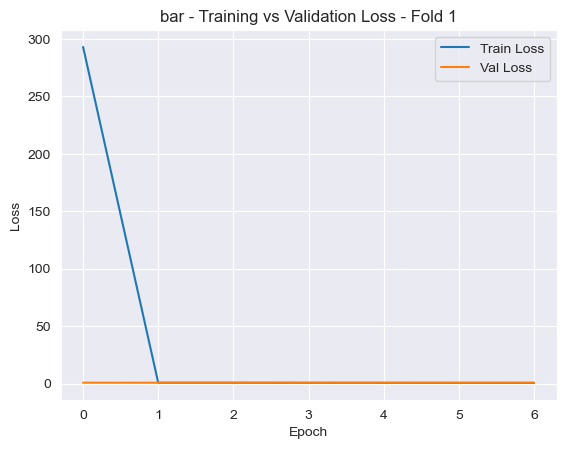

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


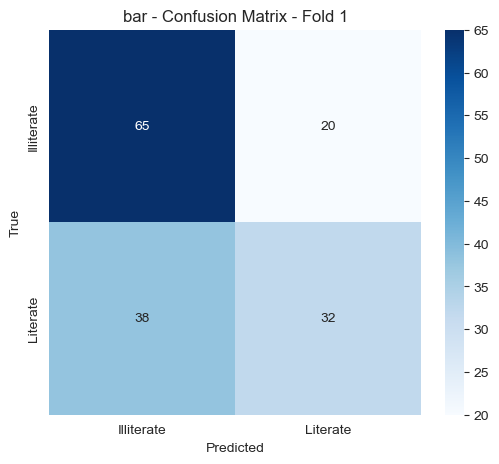

Fold 1 Final Train Acc: 0.7500, Final Val Acc: 0.5871
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.5246 - loss: 153.9956 - val_accuracy: 0.5677 - val_loss: 0.6824
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.5173 - loss: 0.7053 - val_accuracy: 0.5484 - val_loss: 0.6924
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.5754 - loss: 0.6916 - val_accuracy: 0.5484 - val_loss: 0.6914
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.6090 - loss: 0.6883 - val_accuracy: 0.5484 - val_loss: 0.6904


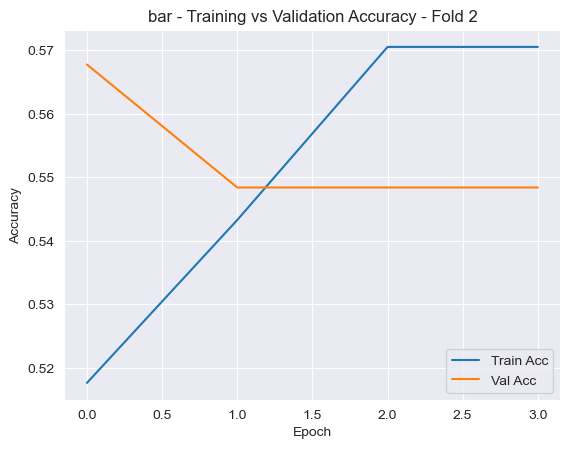

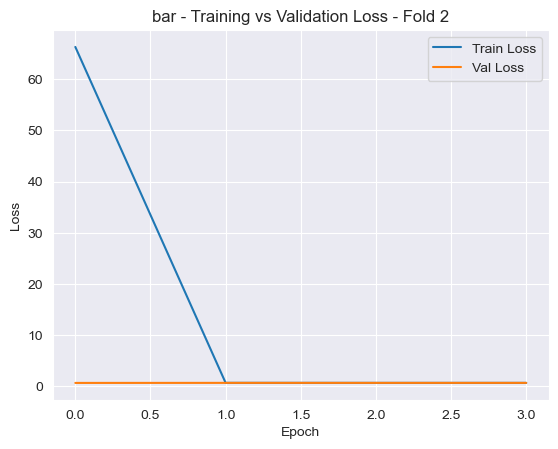

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


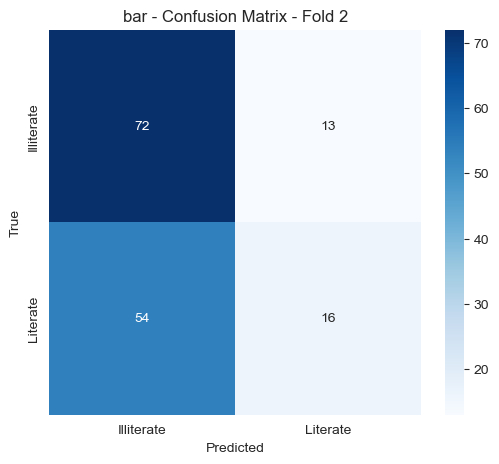

Fold 2 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5233 - loss: 84.8257 - val_accuracy: 0.4516 - val_loss: 0.6934
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.4429 - loss: 0.6934 - val_accuracy: 0.4516 - val_loss: 0.6932
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.4902 - loss: 0.6931 - val_accuracy: 0.5484 - val_loss: 0.6929
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.6090 - loss: 0.6925 - val_accuracy: 0.5484 - val_loss: 0.6926
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.5718 - loss: 0.6922 - val_accuracy: 0.5484 - val_loss: 0.6923
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5883 - loss: 0.6915 - val_accuracy: 0.5484 - val_loss: 0.6920


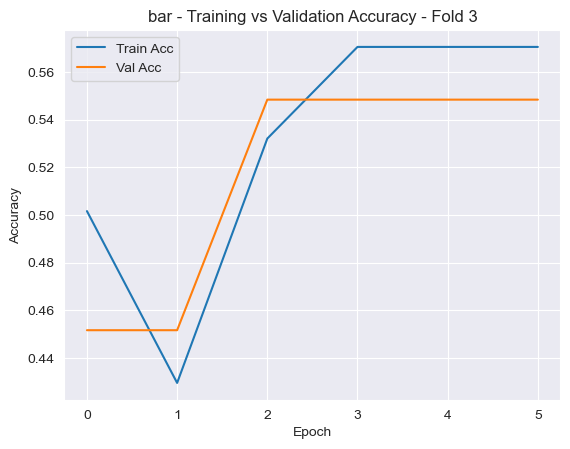

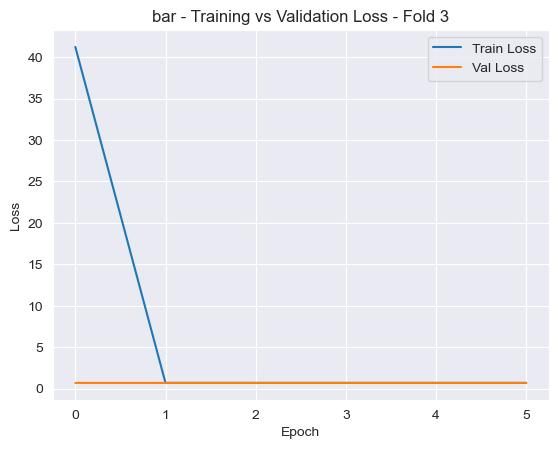

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


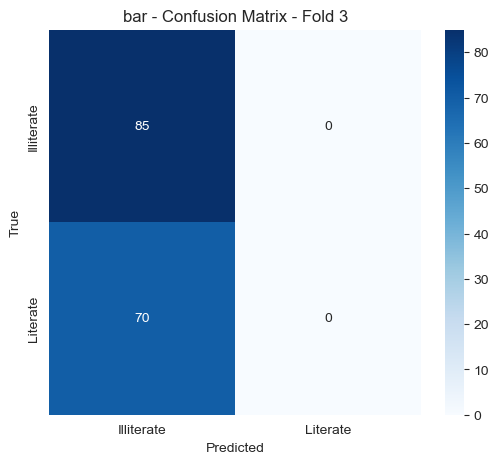

Fold 3 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.5080 - loss: 104.6934 - val_accuracy: 0.4516 - val_loss: 0.6933
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.4564 - loss: 0.6933 - val_accuracy: 0.5484 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.5754 - loss: 0.6928 - val_accuracy: 0.5484 - val_loss: 0.6926
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.6090 - loss: 0.6918 - val_accuracy: 0.5484 - val_loss: 0.6922
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.5718 - loss: 0.6916 - val_accuracy: 0.5484 - val_loss: 0.6919


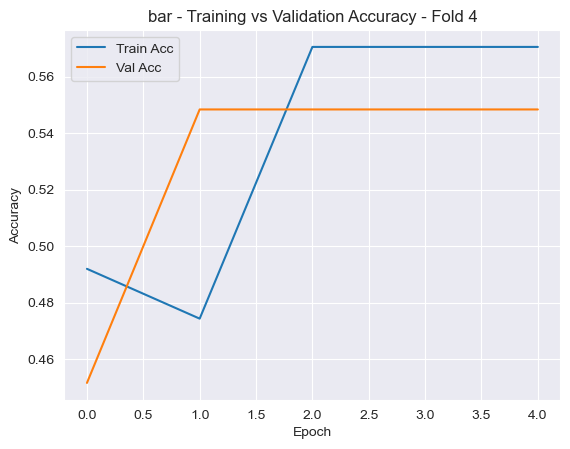

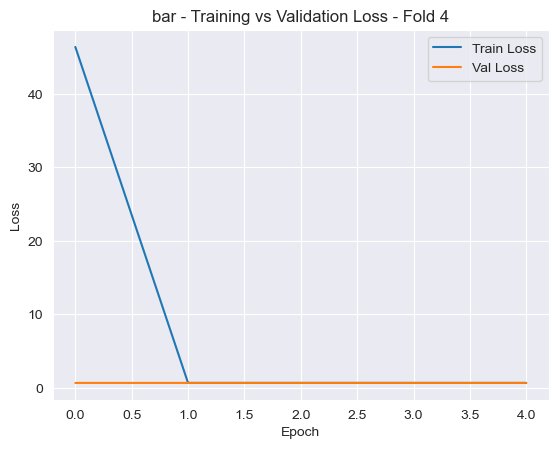

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


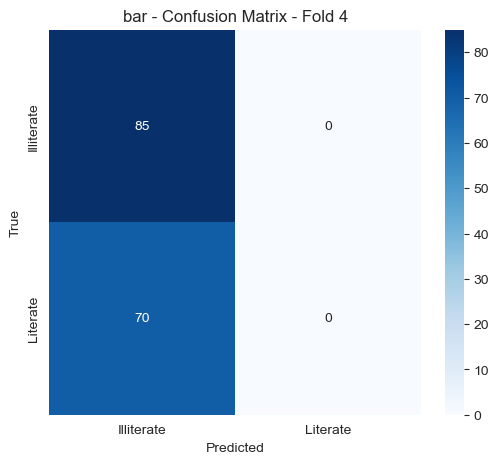

Fold 4 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.5575 - loss: 135.6635 - val_accuracy: 0.5484 - val_loss: 0.6930
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.5571 - loss: 0.6927 - val_accuracy: 0.5484 - val_loss: 0.6922
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.5754 - loss: 0.6914 - val_accuracy: 0.5484 - val_loss: 0.6914
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.6090 - loss: 0.6885 - val_accuracy: 0.5484 - val_loss: 0.6905


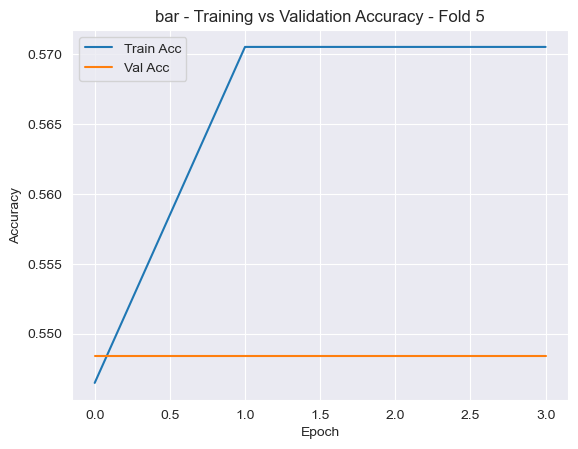

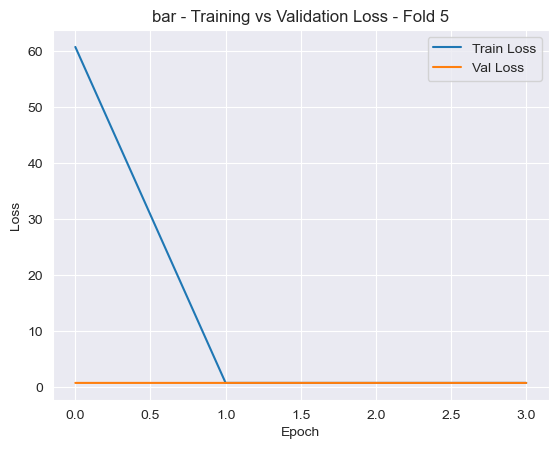

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


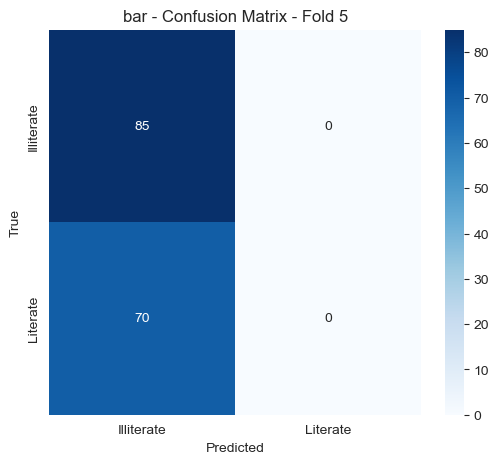

Fold 5 Final Train Acc: 0.5705, Final Val Acc: 0.5484

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.5182 - loss: 51.0731 - val_accuracy: 0.4386 - val_loss: 0.6933
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.4488 - loss: 0.6932 - val_accuracy: 0.5614 - val_loss: 0.6930
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.5483 - loss: 0.6930 - val_accuracy: 0.5614 - val_loss: 0.6926
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.5540 - loss: 0.6926 - val_accuracy: 0.5614 - val_loss: 0.6922
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5452 - loss: 0.6923 - val_accuracy: 0.5614 - val_loss: 0.6917


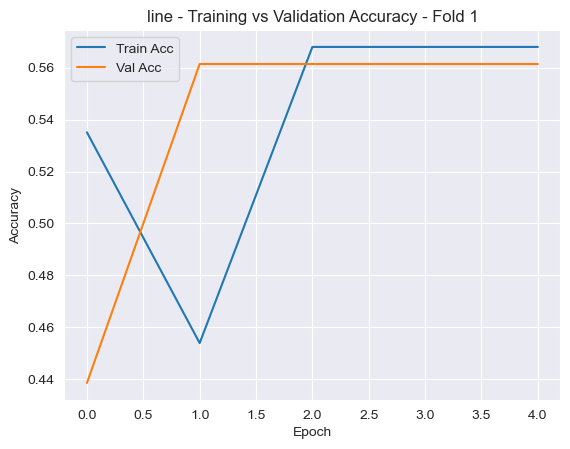

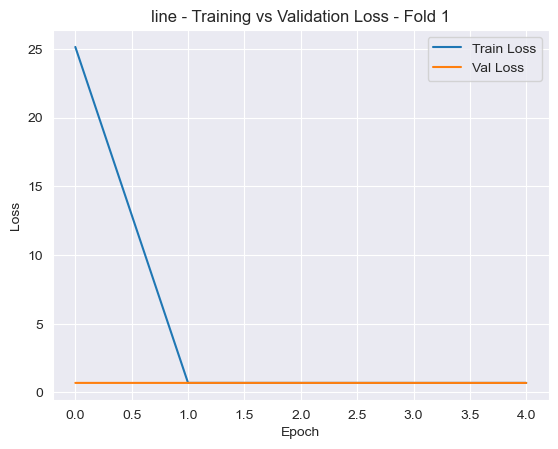

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


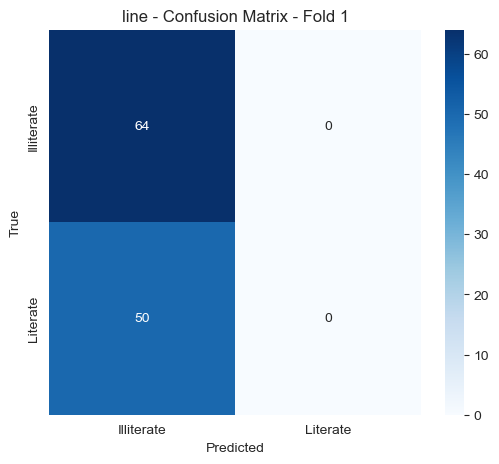

Fold 1 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.4511 - loss: 644.1544 - val_accuracy: 0.5702 - val_loss: 0.6724
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.5910 - loss: 0.6690 - val_accuracy: 0.6053 - val_loss: 0.6710
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.6444 - loss: 0.6220 - val_accuracy: 0.6667 - val_loss: 0.6833
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.7033 - loss: 0.5829 - val_accuracy: 0.6316 - val_loss: 0.6265
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.8023 - loss: 0.4620 - val_accuracy: 0.6404 - val_loss: 0.6566
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.7777 - loss: 0.4272 - val_accuracy: 0.6404 - val_loss: 0.6752


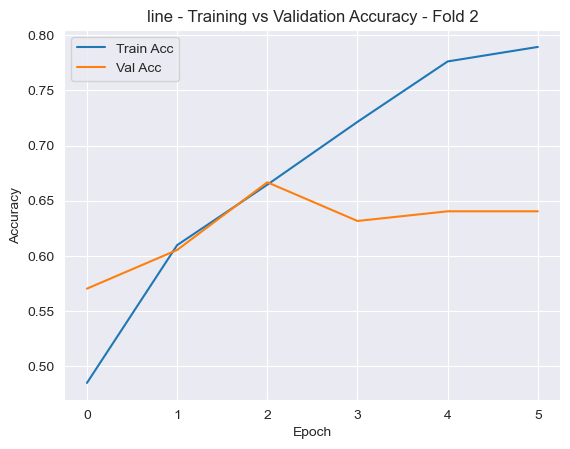

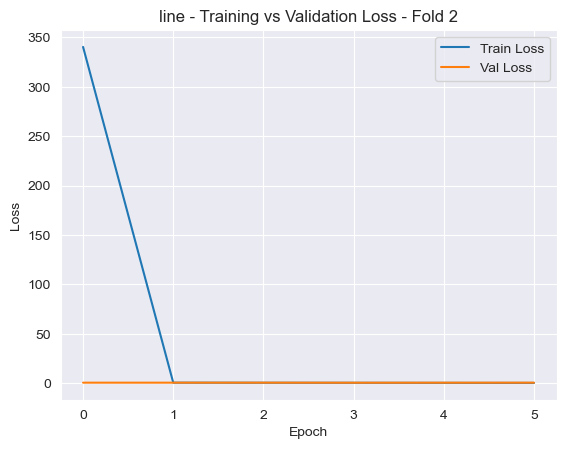

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


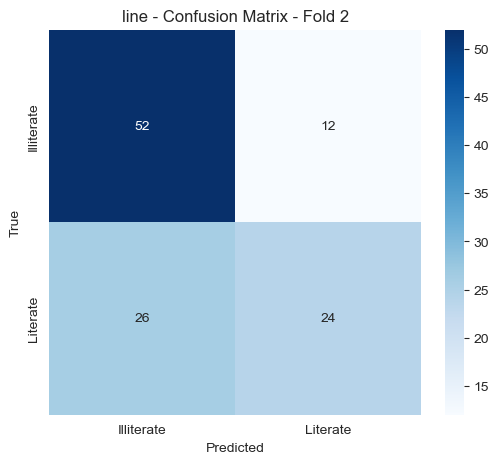

Fold 2 Final Train Acc: 0.7895, Final Val Acc: 0.6404
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.4591 - loss: 497.1316 - val_accuracy: 0.4386 - val_loss: 0.6932
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4793 - loss: 0.7678 - val_accuracy: 0.5614 - val_loss: 0.6931
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5483 - loss: 0.6931 - val_accuracy: 0.5614 - val_loss: 0.6929
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.5540 - loss: 0.6929 - val_accuracy: 0.5614 - val_loss: 0.6926
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.5452 - loss: 0.6927 - val_accuracy: 0.5614 - val_loss: 0.6923


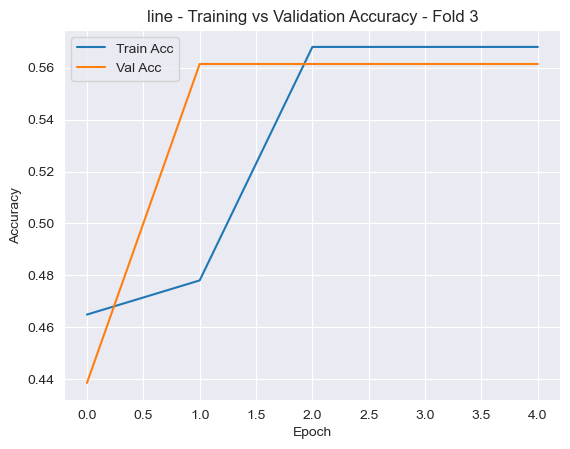

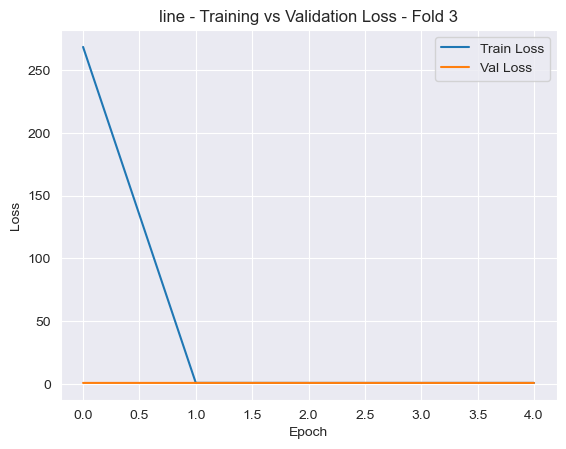

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


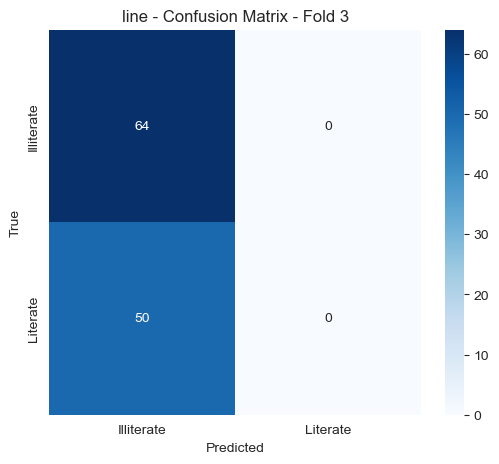

Fold 3 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.5642 - loss: 516.9903 - val_accuracy: 0.5614 - val_loss: 9.0489
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.4984 - loss: 7.7778 - val_accuracy: 0.4737 - val_loss: 0.6869
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.6021 - loss: 0.6709 - val_accuracy: 0.5965 - val_loss: 0.6159
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.6729 - loss: 0.6041 - val_accuracy: 0.7193 - val_loss: 0.5665
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.7503 - loss: 0.4628 - val_accuracy: 0.7544 - val_loss: 0.5473
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.8145 - loss: 0.3937 - val_accuracy: 0.7193 - val_loss: 0.7280
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━

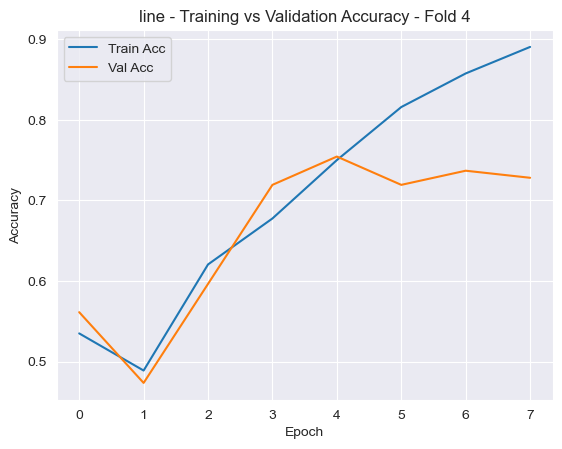

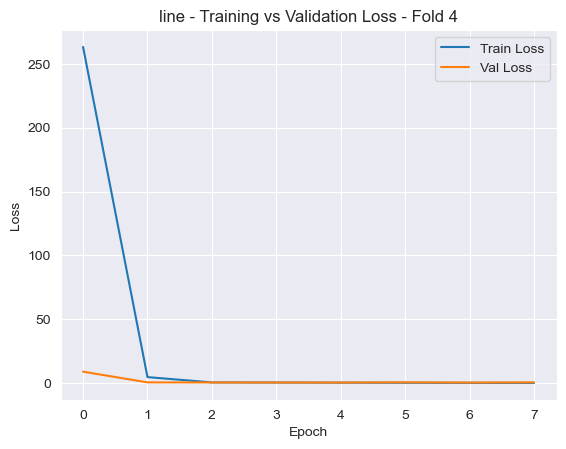

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


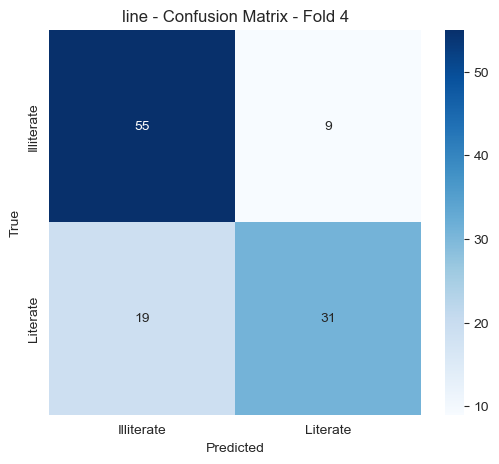

Fold 4 Final Train Acc: 0.8904, Final Val Acc: 0.7281
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.5965 - loss: 115.2667 - val_accuracy: 0.5614 - val_loss: 0.6931
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.5572 - loss: 0.6930 - val_accuracy: 0.5614 - val_loss: 0.6926
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5483 - loss: 0.6926 - val_accuracy: 0.5614 - val_loss: 0.6920
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.5540 - loss: 0.6920 - val_accuracy: 0.5614 - val_loss: 0.6914


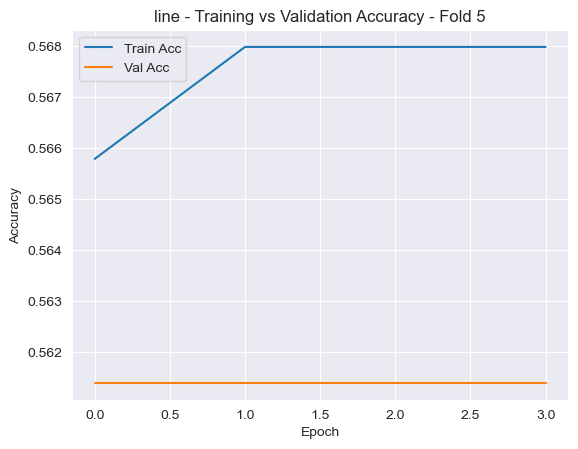

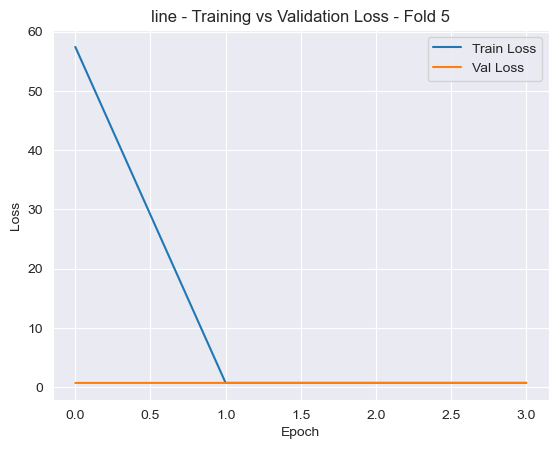

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


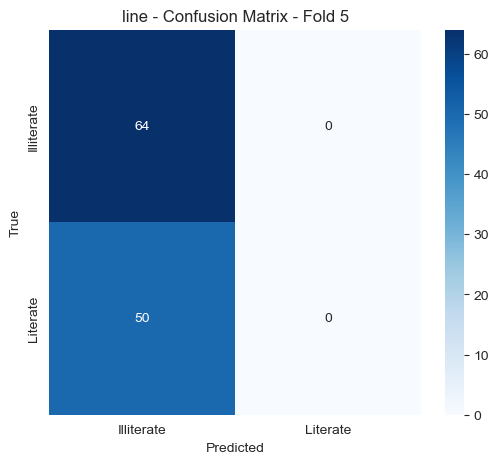

Fold 5 Final Train Acc: 0.5680, Final Val Acc: 0.5614

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.5329 - loss: 809.1420 - val_accuracy: 0.6000 - val_loss: 0.7106
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.4923 - loss: 3.3606 - val_accuracy: 0.4000 - val_loss: 7.1035
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.6175 - loss: 4.9683 - val_accuracy: 0.4000 - val_loss: 1.4954
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.6346 - loss: 0.8848 - val_accuracy: 0.5667 - val_loss: 0.6361


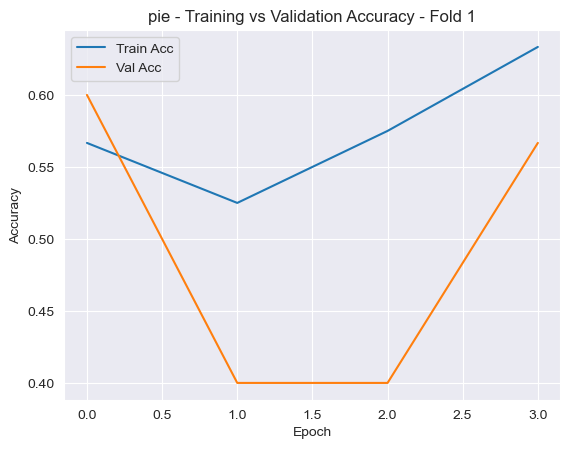

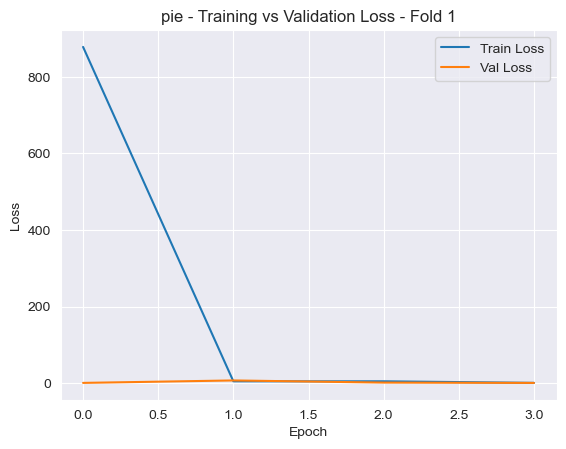

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


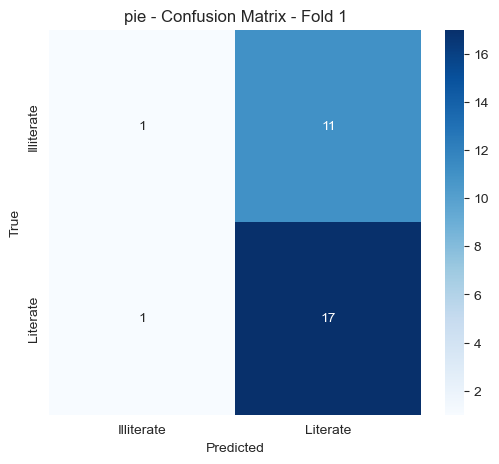

Fold 1 Final Train Acc: 0.6333, Final Val Acc: 0.5667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.4800 - loss: 240.5648 - val_accuracy: 0.6333 - val_loss: 5.4019
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.6152 - loss: 3.4219 - val_accuracy: 0.5000 - val_loss: 1.5859
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6885 - loss: 0.7118 - val_accuracy: 0.6000 - val_loss: 0.6736
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.7442 - loss: 0.6024 - val_accuracy: 0.4333 - val_loss: 0.6937


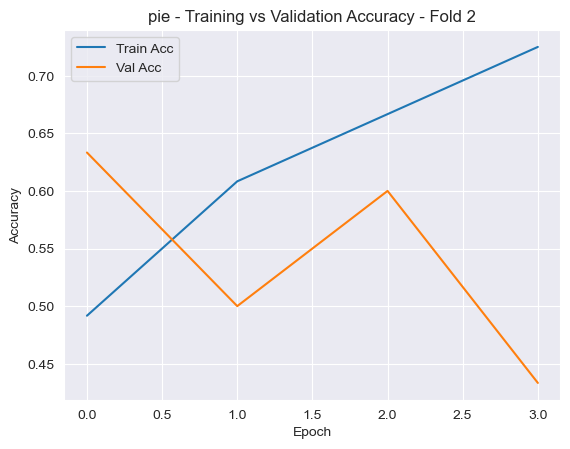

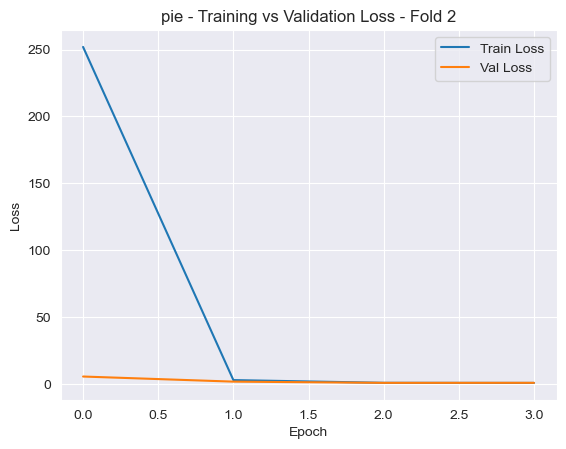

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


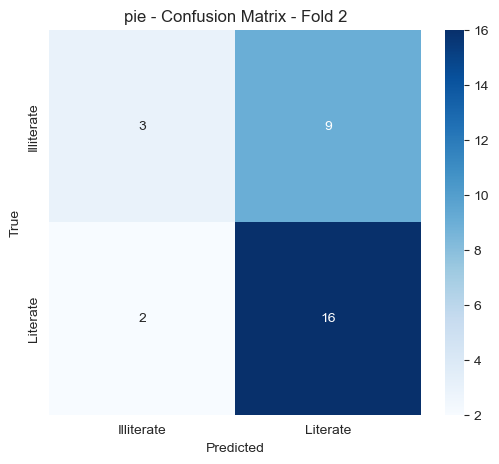

Fold 2 Final Train Acc: 0.7250, Final Val Acc: 0.4333
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.4590 - loss: 620.4309 - val_accuracy: 0.4000 - val_loss: 301.3172
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.5723 - loss: 132.5608 - val_accuracy: 0.6000 - val_loss: 8.3707
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.3754 - loss: 8.8849 - val_accuracy: 0.6000 - val_loss: 0.6931
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.4198 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6933
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6173 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.6936


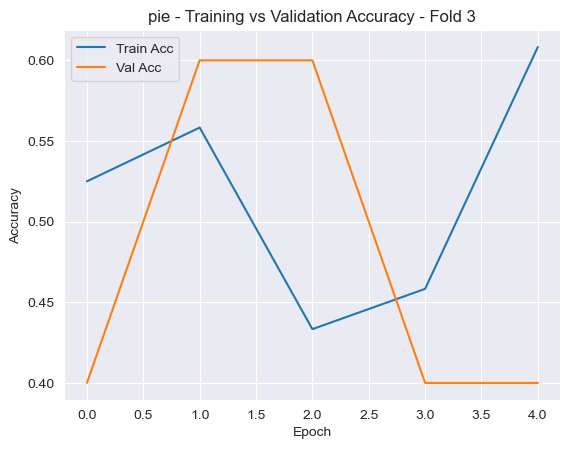

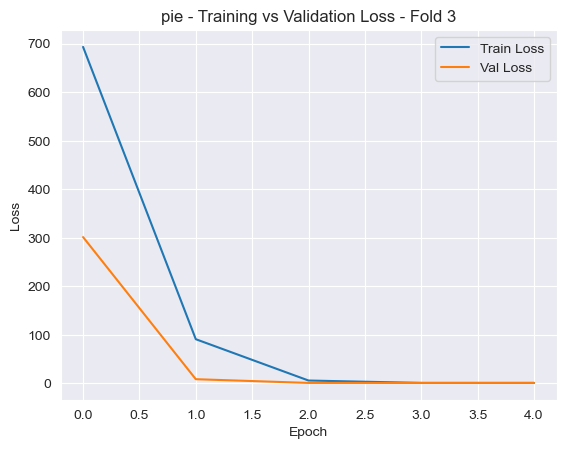

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


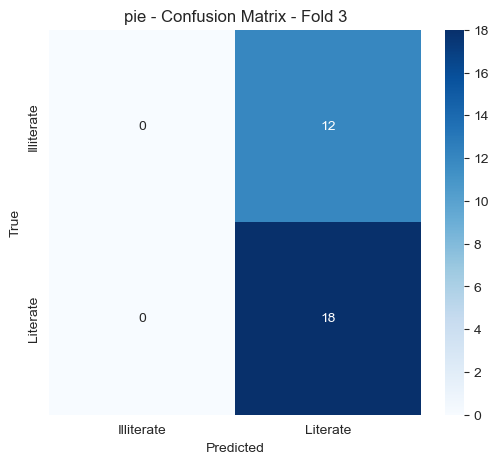

Fold 3 Final Train Acc: 0.6083, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.5744 - loss: 263.8394 - val_accuracy: 0.4000 - val_loss: 142.3264
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.5690 - loss: 64.7283 - val_accuracy: 0.5000 - val_loss: 1.1192
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.6179 - loss: 2.3406 - val_accuracy: 0.7000 - val_loss: 0.6112
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.7110 - loss: 0.6510 - val_accuracy: 0.7333 - val_loss: 0.6107
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.7821 - loss: 0.5701 - val_accuracy: 0.7333 - val_loss: 0.6539
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.7485 - loss: 0.4951 - val_accuracy: 0.7333 - val_loss: 0.6692
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms

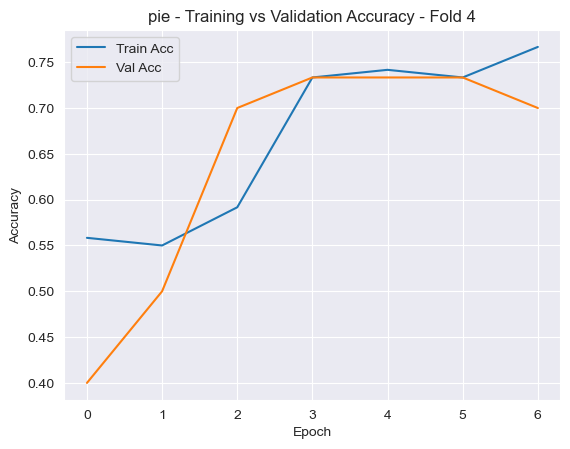

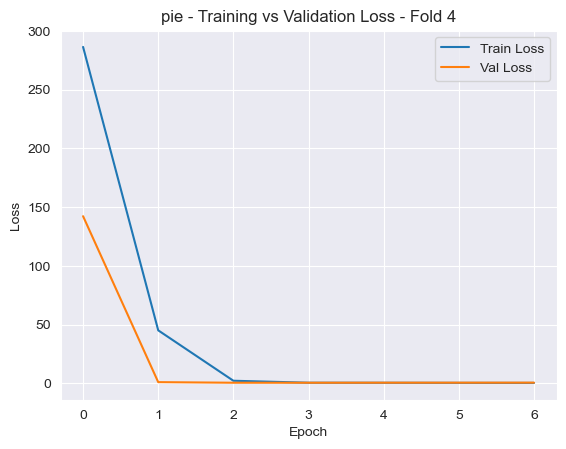

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


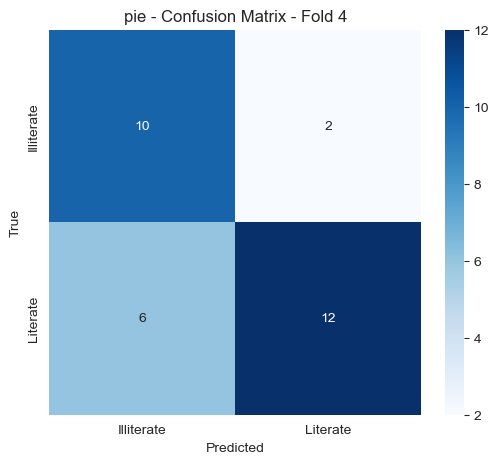

Fold 4 Final Train Acc: 0.7667, Final Val Acc: 0.7000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.4590 - loss: 661.5015 - val_accuracy: 0.4000 - val_loss: 16.1692
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.4669 - loss: 5.9953 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.3483 - loss: 0.6935 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.3765 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.3827 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6932


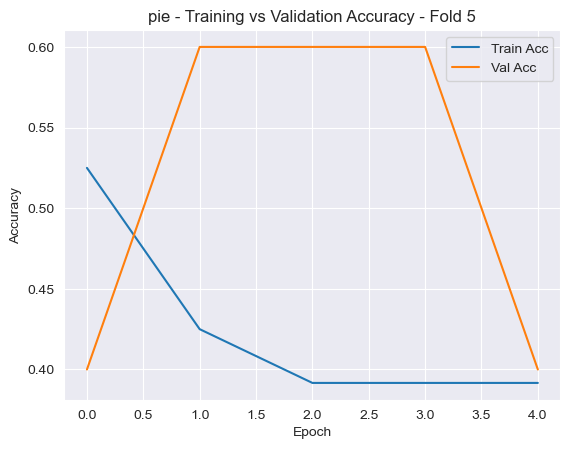

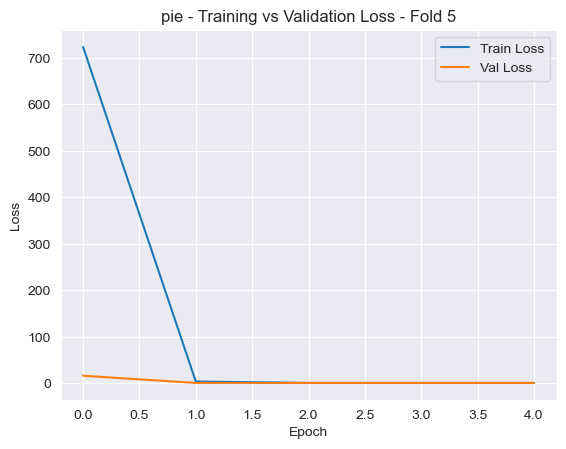

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


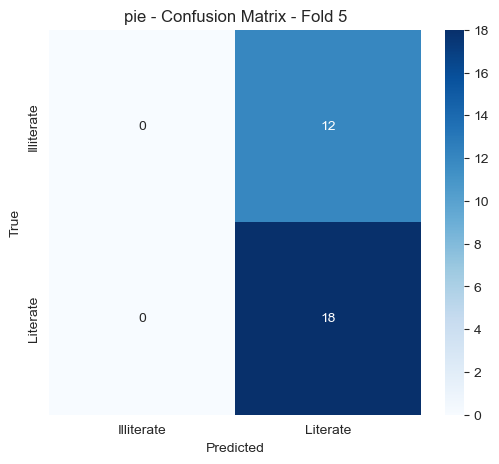

Fold 5 Final Train Acc: 0.3917, Final Val Acc: 0.4000


In [14]:
# Dictionary to hold results per graph type
all_results = {}

# Train and collect results
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Store the mean results for this dataset
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [15]:
# After training all datasets, print summary
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.6064
→ Average Validation Accuracy: 0.5561

Graph Type: line
→ Average Train Accuracy: 0.6768
→ Average Validation Accuracy: 0.6105

Graph Type: pie
→ Average Train Accuracy: 0.6250
→ Average Validation Accuracy: 0.5000
